In [1]:
import warnings
warnings.filterwarnings('ignore')

# ---Playing around with the original MTA dataset.---

This notebook analyzes the MTA subway data for the week of June 10-17, 2017 that can be found here:

http://web.mta.info/developers/turnstile.html

The cell below reads the data in and lists the first few rows:

In [2]:
import pandas as pd

df = pd.read_csv('turnstile_June_17_2017.csv')
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,00:00:00,REGULAR,6215258,2104297
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,04:00:00,REGULAR,6215284,2104303
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,08:00:00,REGULAR,6215318,2104337
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,12:00:00,REGULAR,6215475,2104417
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,16:00:00,REGULAR,6215841,2104465


How big is the data set?

In [3]:
df.shape

(197209, 11)

More specifically, how many stations and turnstiles are there?

In [4]:
stations = len(set(df["STATION"]))

turnstiles = df['C/A'] + ' ' + df['UNIT'] + ' ' + df['SCP'] + ' ' + df['STATION']
turnstiles = len(set(turnstiles))

entries = 7 * 6 * turnstiles # 7 days, 6 data points per day

print('stations', stations)
print('turnstiles', turnstiles)
print('entries', entries)

stations 376
turnstiles 4695
entries 197190


What are the column names? We see that there is a lot of whitespace at the end of the "EXITS" column name so let's strip it:'

In [5]:
print(df.columns)
df.columns = df.columns.str.strip()
print(df.columns)

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')
Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')


If we wanted to only look at the 34st Street Penn Station stop on 6/12/2017, we could type the following:

In [6]:
penn = df[(df['STATION'] == '34 ST-PENN STA') & (df['DATE'] == '06/12/2017')]
penn = penn.reset_index(drop=True)
penn.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,06/12/2017,00:00:00,REGULAR,1829493,1553798
1,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,06/12/2017,04:00:00,REGULAR,1829495,1553801
2,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,06/12/2017,08:00:00,REGULAR,1829676,1553947
3,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,06/12/2017,12:00:00,REGULAR,1829944,1554414
4,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,06/12/2017,16:00:00,REGULAR,1829981,1554571


To subtract the entry and exit counters in order to get the number of people passing through:

In [7]:
penn['ENTRY_DIFF'] = 0
penn['EXIT_DIFF'] = 0

for i in range(1,len(penn)):
    penn['ENTRY_DIFF'][i] = penn['ENTRIES'][i]-penn['ENTRIES'][i-1]
    penn['EXIT_DIFF'][i] = penn['EXITS'][i]-penn['EXITS'][i-1]
penn.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ENTRY_DIFF,EXIT_DIFF
0,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,06/12/2017,00:00:00,REGULAR,1829493,1553798,0,0
1,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,06/12/2017,04:00:00,REGULAR,1829495,1553801,2,3
2,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,06/12/2017,08:00:00,REGULAR,1829676,1553947,181,146
3,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,06/12/2017,12:00:00,REGULAR,1829944,1554414,268,467
4,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,06/12/2017,16:00:00,REGULAR,1829981,1554571,37,157


# ---Playing around with a cleaned up, simplifed version of the dataset.---
Let's read a cleaned data file containing a dictionary of the data back in:

In [1]:
import pickle
bigDict = pickle.load( open( "MTAdict.pkl", "rb" ) )

To figure out the number of people through a given turnstile during a given time period, we'll use the getTurnstileInfo function. 

The example below finds the number of people through the 02-00-00 Wall Street turnstile between midnight on 6/12 and 6/13:

In [15]:
from datetime import datetime as dt

def cleanPeople(n): #Just a cleanup function
    if(n<0): #can't have negative people
        return 0
    if(n>9000000): #can't have more people than the population of NYC passing through one turnstile in 4 hrs
        return 0
    return n

def getTurnstileInfo(turnstileList,startTime,endTime):
    ret = 0 #Return Value
    n = len(turnstileList)
    totalTime = endTime-startTime
    for i in range(n-1): 
        ti = turnstileList[i][0]
        tf = turnstileList[i+1][0]
        if((tf<startTime) or (ti>endTime)):
            continue #Non-overlap Time Segment
        #For Overlapping Time, find a linear approximation for number of people in a given time period
        segmentTime = min(tf,endTime) - max(ti,startTime)
        fullSegment = tf-ti
        # if the time segment is actually 0, return 0 people
        noDay = dt(2017,6,12,0,0,0)-dt(2017,6,12,0,0,0)
        if(fullSegment==noDay): 
            return 0
        weight = segmentTime/fullSegment
        peopleCount = turnstileList[i+1][1]-turnstileList[i][1]
        peopleCount = cleanPeople(peopleCount)
        ret+= (weight)*peopleCount
    return int(ret)

t1 = dt.strptime("2017-06-12 00:00:00","%Y-%m-%d %H:%M:%S")
t2 = dt.strptime("2017-06-13 00:00:00","%Y-%m-%d %H:%M:%S")
getTurnstileInfo(bigDict[('R204', 'R043', 'WALL ST')]["02-00-00"],t1,t2)

1419

To get the total station area info (instead of just a single turnstile info), we'll use the getStationAreaInfo function. The example below tallies all of the riders through the ('R204', 'R043', 'WALL ST') station area between 6/12 and 6/13.

In [3]:
def getStationAreaInfo(stationDict,startTime,endTime):
    ret = 0
    for turnstile,exit_counter in stationDict.items():
        cur = getTurnstileInfo(exit_counter,startTime,endTime)
        ret+= cur
    return ret

ans = getStationAreaInfo(bigDict[('R204', 'R043', 'WALL ST')],dt(2017,6,12,0,0,0),dt(2017,6,13,0,0,0))
print(ans)

9507


Remember that there can be multiple Wall Street Station Areas within the Wall Street station. Let's tally them up and plot the total Wall St Station riders versus date:

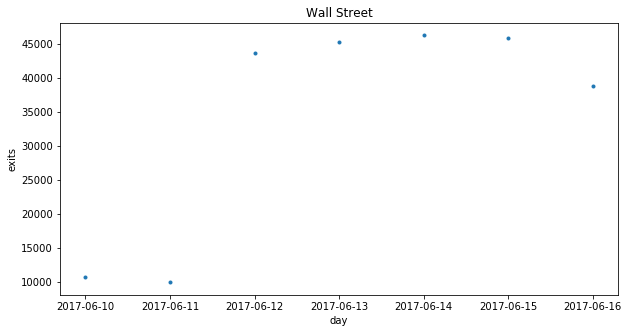

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

mon,tue,wed,thu,fri,sat,sun = 0,0,0,0,0,0,0

for station in bigDict.keys():
    if station[2] == 'WALL ST':
        sat = sat + getStationAreaInfo(bigDict[station], dt(2017,6,10,0,0,0),dt(2017,6,11,0,0,0))
        sun = sun + getStationAreaInfo(bigDict[station], dt(2017,6,11,0,0,0),dt(2017,6,12,0,0,0))
        mon = mon + getStationAreaInfo(bigDict[station], dt(2017,6,12,0,0,0),dt(2017,6,13,0,0,0))
        tue = tue + getStationAreaInfo(bigDict[station], dt(2017,6,13,0,0,0),dt(2017,6,14,0,0,0))
        wed = wed + getStationAreaInfo(bigDict[station], dt(2017,6,14,0,0,0),dt(2017,6,15,0,0,0))
        thu = thu + getStationAreaInfo(bigDict[station], dt(2017,6,15,0,0,0),dt(2017,6,16,0,0,0))
        fri = fri + getStationAreaInfo(bigDict[station], dt(2017,6,16,0,0,0),dt(2017,6,17,0,0,0))
counts = [sat, sun, mon, tue, wed, thu, fri]   

days = [ dt(2017,6,10,0,0,0), 
        dt(2017,6,11,0,0,0), 
        dt(2017,6,12,0,0,0), 
        dt(2017,6,13,0,0,0), 
        dt(2017,6,14,0,0,0), 
        dt(2017,6,15,0,0,0), 
        dt(2017,6,16,0,0,0)]

plt.rcParams['figure.figsize'] = [10,5]
plt.plot(days, counts,'.')
plt.xlabel('day')
plt.ylabel('exits')
plt.title('Wall Street')

### FULL STATION TOTALS

Let's create a station list containing the station area totals between midnight of June 12 and June 13. Let's sort it to see the busiest station areas:


In [5]:
station_list_June12 = []
for station in bigDict.keys():
    station_list_June12 .append((getStationAreaInfo(bigDict[station],dt(2017,6,12,0,0,0),dt(2017,6,13,0,0,0)), station))
station_list_June12 .sort(reverse = True)
station_list_June12 [0:20]

[(57270, ('PTH22', 'R540', 'PATH NEW WTC')),
 (54169, ('R238', 'R046', 'GRD CNTRL-42 ST')),
 (36343, ('R249', 'R179', '86 ST')),
 (35517, ('R240', 'R047', 'GRD CNTRL-42 ST')),
 (30835, ('R533', 'R055', 'FLUSHING-MAIN')),
 (28806, ('H009', 'R235', 'BEDFORD AV')),
 (28039, ('N324', 'R018', 'JKSN HT-ROOSVLT')),
 (27867, ('N500', 'R020', '47-50 STS ROCK')),
 (27437, ('A025', 'R023', '34 ST-HERALD SQ')),
 (27378, ('PTH03', 'R552', 'JOURNAL SQUARE')),
 (27245, ('R138', 'R293', '34 ST-PENN STA')),
 (26662, ('N506', 'R022', '34 ST-HERALD SQ')),
 (25941, ('N049', 'R084', '59 ST COLUMBUS')),
 (25865, ('R221', 'R170', '14 ST-UNION SQ')),
 (25506, ('N507', 'R023', '34 ST-HERALD SQ')),
 (25330, ('N063A', 'R011', '42 ST-PORT AUTH')),
 (24698, ('N083', 'R138', 'W 4 ST-WASH SQ')),
 (24668, ('A034', 'R170', '14 ST-UNION SQ')),
 (24245, ('N306', 'R017', 'LEXINGTON AV/53')),
 (23432, ('R169', 'R168', '96 ST'))]


There are still several station areas within a station. Let's make a total dictionary that contains the total rider exits through each station on June 12. Then let's sort it:

In [6]:
total_dict = {}
for item in station_list_June12 :
    total_dict[item[1][2]] = int(total_dict.get(item[1][2],0) + item[0])
    
rider_list = []
for station, riders in total_dict.items():
    rider_list.append((riders, station))

rider_list.sort(reverse = True)
for rider_info in rider_list:
    print(rider_info)

(136834, '34 ST-PENN STA')
(135077, 'GRD CNTRL-42 ST')
(109563, '34 ST-HERALD SQ')
(91048, 'TIMES SQ-42 ST')
(88400, '14 ST-UNION SQ')
(85480, '23 ST')
(81102, 'FULTON ST')
(72934, '42 ST-PORT AUTH')
(72796, '86 ST')
(62141, '47-50 STS ROCK')
(58523, '125 ST')
(57270, 'PATH NEW WTC')
(57251, '59 ST')
(55966, '59 ST COLUMBUS')
(55860, 'CANAL ST')
(50766, 'CHAMBERS ST')
(48903, '96 ST')
(47857, '14 ST')
(47196, 'LEXINGTON AV/53')
(46467, '72 ST')
(46095, 'FLUSHING-MAIN')
(43671, 'WALL ST')
(42835, '28 ST')
(40872, '42 ST-BRYANT PK')
(39204, 'ATL AV-BARCLAY')
(38847, '50 ST')
(37885, 'JKSN HT-ROOSVLT')
(36072, 'W 4 ST-WASH SQ')
(35474, '7 AV')
(33735, 'JAMAICA CENTER')
(30358, '145 ST')
(29966, 'BOWLING GREEN')
(29226, '77 ST')
(28806, 'BEDFORD AV')
(28599, '5 AV/53 ST')
(27561, 'KEW GARDENS')
(27378, 'JOURNAL SQUARE')
(27153, 'LEXINGTON AV/63')
(27060, "B'WAY-LAFAYETTE")
(27058, 'CHURCH AV')
(26265, '8 AV')
(25904, 'KINGS HWY')
(25459, 'GRAND ST')
(25166, '72 ST-2 AVE')
(23761, 'BOROUGH 

Let's make a histogram of station totals:

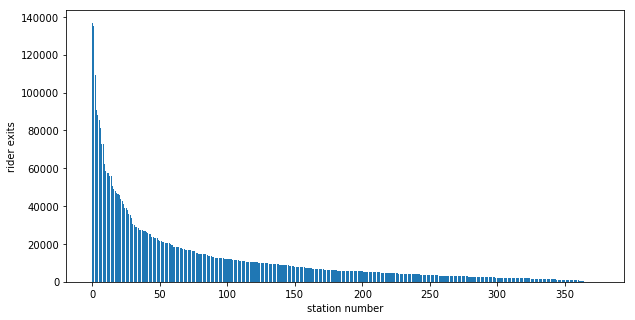

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

station = range(len(rider_list))
riders = [rider_list[i][0] for i in station]

plt.rcParams['figure.figsize'] = [10,5]
plt.bar(station, riders)
plt.xlabel('station number')
plt.ylabel('rider exits')


## Commuter?

Let's create a commuter index to be the average weekday exits divided by (avg weekday exits + avg weekend exits). To do this, we'll first make functions that test whether a date is a weekday or not and get the day of week (Sunday, Monday, etc.)

In [8]:
def isWeekday(t): #Input: Datetime object Output: True if it is weekday, False otherwise
    s = int(t.strftime("%w"))
    if(s>=1 and s<=5):
        return True
    return False

def getDayOfWeek(t): # 0: Sunday, 1: Monday, etc.
    return int(t.strftime("%w"))

#Example Usage
d1 = dt(2017,6,12,0,0,0)
print(isWeekday(d1))

True


Now let's make the commuter index and test it on the ('R204', 'R043', 'WALL ST') station area:

In [17]:
import numpy as np
def getCommuteIndex(st):
    startDate = dt(2017,6,10,0,0,0)
    weekday = []
    weekend = []
    for i in range(21):
        oneDay = dt(2017,6,13,0,0,0)-dt(2017,6,12,0,0,0)
        people = getStationAreaInfo(bigDict[st],startDate,startDate+oneDay)
        if(isWeekday(startDate)):
            weekday.append(people)
        else:
            weekend.append(people)
        startDate += oneDay
    dayavg = np.average(weekday)
    endavg = np.average(weekend)
    if endavg==0:
        return 0
    idx = dayavg/(dayavg+endavg)
    return idx

#Example Usage
q = getCommuteIndex(('R204', 'R043', 'WALL ST'))
print(q)

0.9142900557470772


That's really high! Let's get the commuter index for all of the station areas:

In [19]:
commuteRanking = []
for station_area in bigDict.keys():
    idx = getCommuteIndex(station_area)
    commuteRanking.append((idx,station_area))

commuteRanking.sort(reverse = True)
for station in commuteRanking:
    print(station[0],station[1])

0.9997511653754915 ('R634', 'R069', 'NEW LOTS AV')
0.9992930863848438 ('R242A', 'R049', '51 ST')
0.9992276202981386 ('R204A', 'R043', 'WALL ST')
0.9991714603602964 ('R237', 'R046', 'GRD CNTRL-42 ST')
0.9990563070147845 ('N412', 'R299', 'BROADWAY')
0.999009861776704 ('R230', 'R143', '28 ST')
0.9988500837796104 ('R633', 'R068', 'VAN SICLEN AV')
0.9987639060568604 ('R137', 'R031', '34 ST-PENN STA')
0.9983459591782725 ('R629', 'R065', 'ROCKAWAY AV')
0.9972474538948527 ('R632', 'R067', 'PENNSYLVANIA AV')
0.9970398631758979 ('N405', 'R239', 'GREENPOINT AV')
0.9965086507874932 ('C016', 'R278', '25 ST')
0.9961351862511307 ('R628', 'R064', 'SARATOGA AV')
0.9960146660290132 ('N318', 'R298', 'NORTHERN BLVD')
0.9957847095886765 ('N415', 'R286', 'MYRTLE-WILLOUGH')
0.9956817559454848 ('R112A', 'R027', 'WALL ST')
0.9954828418571167 ('N508', 'R453', '23 ST')
0.9937185929648241 ('N414', 'R316', 'FLUSHING AV')
0.9921383647798743 ('N414A', 'R316', 'FLUSHING AV')
0.9913849588662121 ('N408A', 'R256', 'NASS

0.4547079856972586 ('R314', 'R406', 'PROSPECT AV')
0.4461802443209466 ('R322', 'R386', '174 ST')
0.44300097434231894 ('N203', 'R195', '161/YANKEE STAD')
0.43051890941072996 ('N417', 'R269', 'BEDFORD-NOSTRAN')
0.42861861117991906 ('N187', 'R419', 'ROCKAWAY PARK B')
0.41783032650426394 ('D016', 'R397', '86 ST')
0.41661173368490445 ('TRAM2', 'R469', 'RIT-ROOSEVELT')
0.4154802486464808 ('R318', 'R408', 'SIMPSON ST')
0.41037735849056606 ('OB01', 'R459', 'ORCHARD BEACH')
0.4077757685352622 ('N183', 'R415', 'BROAD CHANNEL')
0.3979303857008467 ('N003', 'R185', 'DYCKMAN ST')
0.3884248713405889 ('G011', 'R312', 'W 8 ST-AQUARIUM')
0.38241839762611274 ('N186', 'R418', 'BEACH 105 ST')
0.3743996764572064 ('N185', 'R417', 'BEACH 98 ST')
0.37098983490736065 ('N184', 'R416', 'BEACH 90 ST')
0.34486515935712336 ('R320', 'R409', 'FREEMAN ST')
0.00044548390689386344 ('R262B', 'R195', '161/YANKEE STAD')
0.00020876100344455656 ('R262A', 'R195', '161/YANKEE STAD')
0 ('S102', 'R165', 'TOMPKINSVILLE')
0 ('S101A

Remember that there are still several station areas within each station. Let's get all of the commuter indexes for each station area and then take the median of that commuter index to assign to the entire station:

In [20]:
import numpy as np

commuter_dict = {}
for station in bigDict.keys():
    idx = getCommuteIndex(station)
    commuter_dict[station[2]] = commuter_dict.get(station[2], []) + [idx]

commuter_list = []
for station, indexes in commuter_dict.items():
    commuter_list.append((np.median(indexes), station))

commuter_list.sort(reverse = True)

for info in commuter_list:
    print(info)

(0.9997511653754915, 'NEW LOTS AV')
(0.9972474538948527, 'PENNSYLVANIA AV')
(0.9970398631758979, 'GREENPOINT AV')
(0.9961351862511307, 'SARATOGA AV')
(0.9921383647798743, 'FLUSHING AV')
(0.9918046924566759, 'MYRTLE-WILLOUGH')
(0.9913849588662121, 'NASSAU AV')
(0.9353417649566577, 'BAY 50 ST')
(0.9308408339103008, 'BOWLING GREEN')
(0.891933474979852, '25 AV')
(0.861607050713121, 'THIRTY ST')
(0.852875091487838, '5 AV/53 ST')
(0.8420157984201581, 'LACKAWANNA')
(0.8378077200096461, 'WALL ST')
(0.8260323427878745, 'NEWARK HW BMEBE')
(0.816057346842834, 'FULTON ST')
(0.8108931354836424, 'NORTHERN BLVD')
(0.8106149103362604, '47-50 STS ROCK')
(0.8074075998026026, 'LEXINGTON AV/53')
(0.8051772157914188, '25 ST')
(0.8018751483867965, 'BROADWAY')
(0.7997926788255938, 'FRANKLIN ST')
(0.7996845425867507, 'HUNTERS PT AV')
(0.7979288286024461, 'VAN SICLEN AV')
(0.7947325761967224, 'UNION ST')
(0.794695345234983, 'HOUSTON ST')
(0.7899727167130391, 'ELMHURST AV')
(0.7875319527816872, 'PATH WTC 2')
(0

Or to see the most touristy stops, we'll sort in the other order:

In [21]:
commuter_list.sort(reverse = False)

for info in commuter_list:
    print(info)

(0.0, '21 ST')
(0.0, 'JUNIUS ST')
(0.0, 'ST. GEORGE')
(0.0, 'SUTTER AV-RUTLD')
(0.0, 'TOMPKINSVILLE')
(0.3441427853192559, 'AVENUE N')
(0.37098983490736065, 'BEACH 90 ST')
(0.3743996764572064, 'BEACH 98 ST')
(0.38241839762611274, 'BEACH 105 ST')
(0.4077757685352622, 'BROAD CHANNEL')
(0.41037735849056606, 'ORCHARD BEACH')
(0.41661173368490445, 'RIT-ROOSEVELT')
(0.42861861117991906, 'ROCKAWAY PARK B')
(0.44300097434231894, '161/YANKEE STAD')
(0.45683375916137037, 'BEDFORD-NOSTRAN')
(0.46644685616510784, 'YORK ST')
(0.47101464369779406, 'BEACH 67 ST')
(0.4734389561975769, 'AQUEDUCT RACETR')
(0.4747766989931784, 'W 8 ST-AQUARIUM')
(0.47597132382541113, 'DYCKMAN ST')
(0.4860504888072083, 'BEDFORD AV')
(0.4968251562157883, 'BOWERY')
(0.499189947934058, 'MONTROSE AV')
(0.49998705635662327, 'LAFAYETTE AV')
(0.5108184383819379, '238 ST')
(0.5112960760998811, 'CLARK ST')
(0.5114938764817605, 'JFK JAMAICA CT1')
(0.51171875, 'BROAD ST')
(0.5133184546648609, 'OCEAN PKWY')
(0.5143824027072758, '121 